In [5]:
# Important stuff
import os
import sys
from pathlib import Path
import json
import numpy as np
from typing import Tuple, Dict

# Enables the notebook to access root:
root_path = Path.cwd().parent
sys.path.append(str(root_path))

# Repo stuff
from geometry_metrics import compute_spectral_entropy, cosine_similarity_matrix, sliding_window, calculate_angles, plot_similarity_heatmap
from se_correlation import encode_labelset, compute_entropies

# Plots and pandas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
import umap
from sklearn.decomposition import PCA

# CLIP/Torch
import clip
import torch
from torchvision.datasets import CIFAR100

# Statistics stuff
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import gaussian_kde

import warnings
# Suppress UMAP warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading CLIP ViT-L/14@336px...")
#Force the model to use float32:
model = clip.load("ViT-L/14@336px", jit=False, device=torch.device("cpu"))[0].to(device)
print(torch.version)
print(torch.version.hip)
print(torch.cuda.is_available()) 
print(torch.device("cuda"))

Loading CLIP ViT-L/14@336px...
<module 'torch.version' from '/home/friis/.local/lib/python3.12/site-packages/torch/version.py'>
6.4.43483-a187df25c
True
cuda


In [3]:
Dataset = "Dataset" #coil100 doesn't want to work atm
embedding_path = f"../Embeddings/{Dataset}.json"
label_path = f"../Data/{Dataset}/labels.json"

with open(embedding_path, "r", encoding="utf-8") as f:
    embedding_dict = json.load(f)["rot"]

for obj in embedding_dict:
    embedding_dict[obj] = np.array(
        [embedding_dict[obj][str(key)] for key in sorted(map(int, embedding_dict[obj].keys()))],
        dtype=np.float32
    )

def UMAP_projection(embeddings, random_seed = 42):
    reducer = umap.UMAP(random_state=random_seed)
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

Analyzing 'cup_no_handle'...


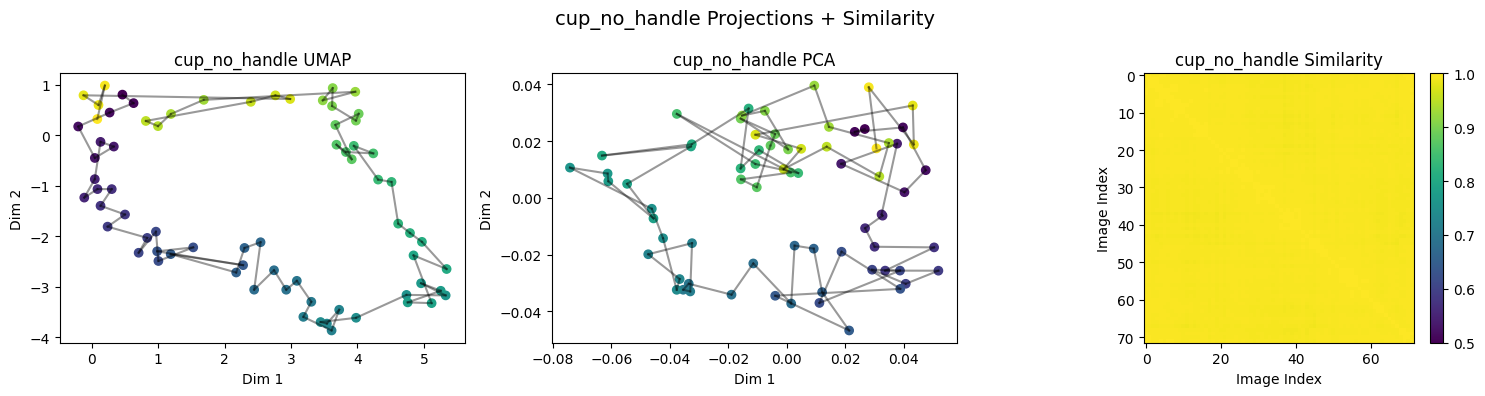

Analyzing 'charger'...


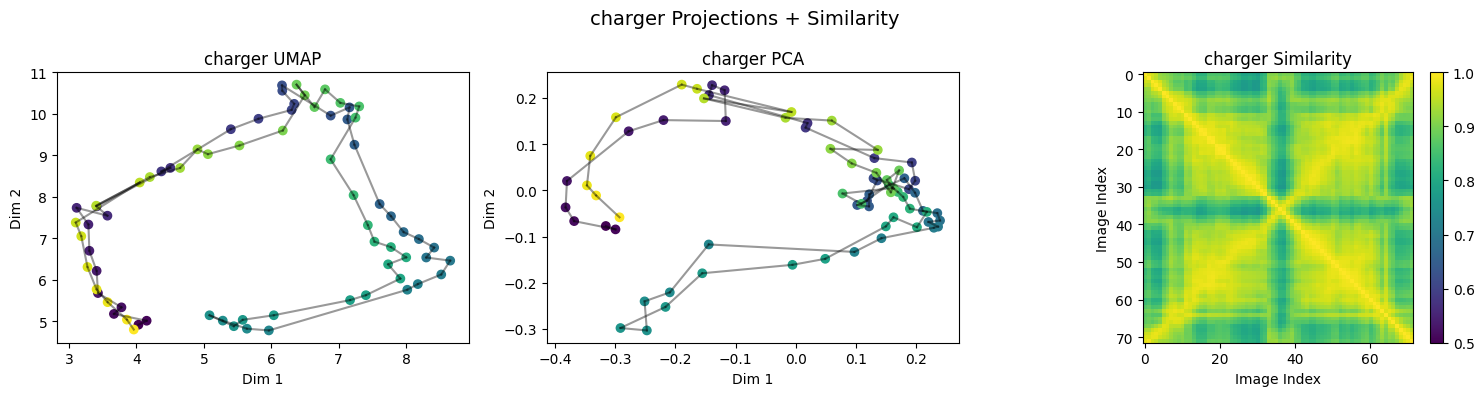

Analyzing 'rubiks_cube'...


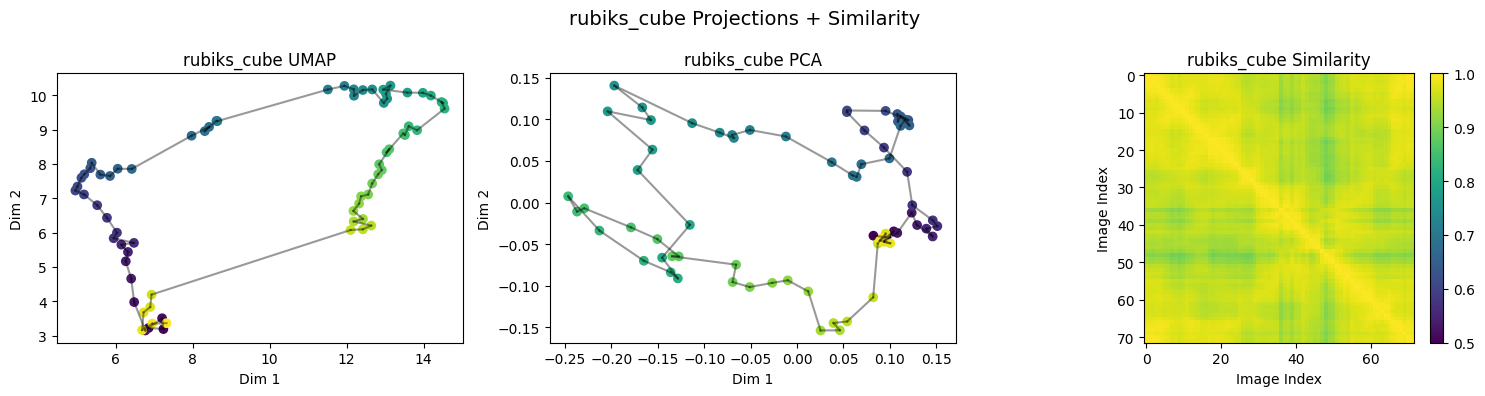

Analyzing 'rubber_duck'...


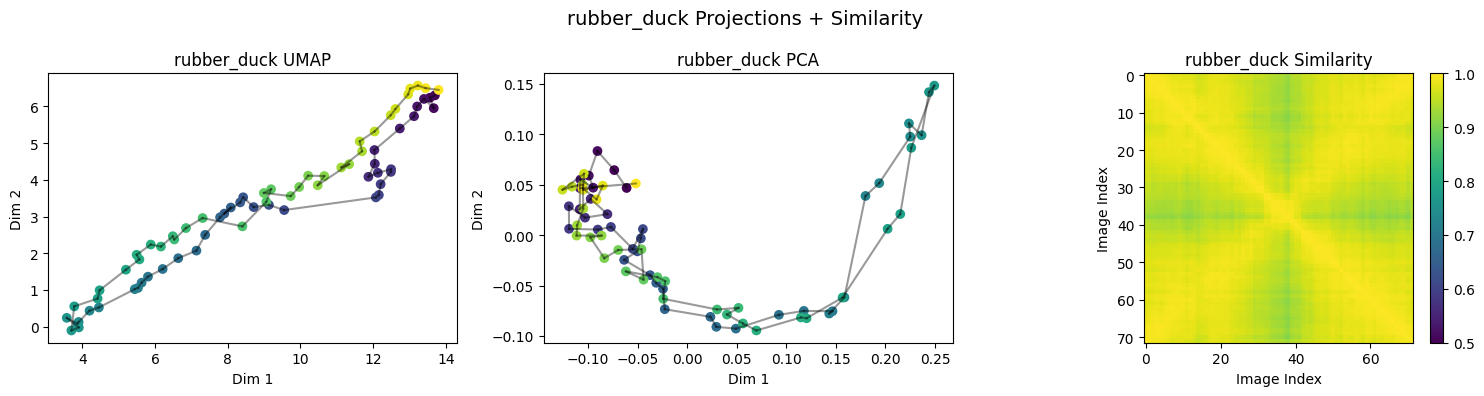

Analyzing 'battery'...


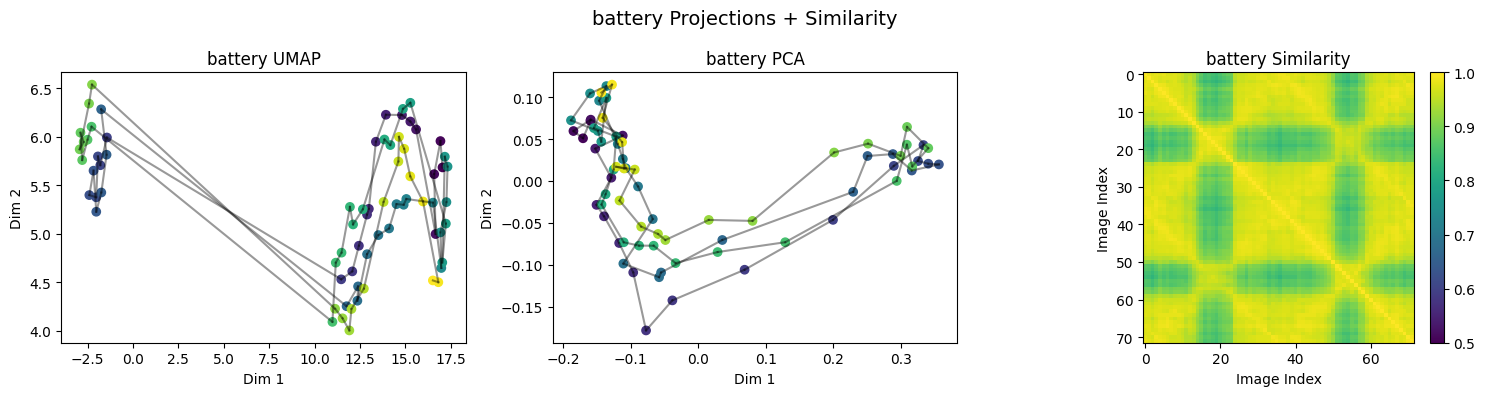

Analyzing 'thermo_cup'...


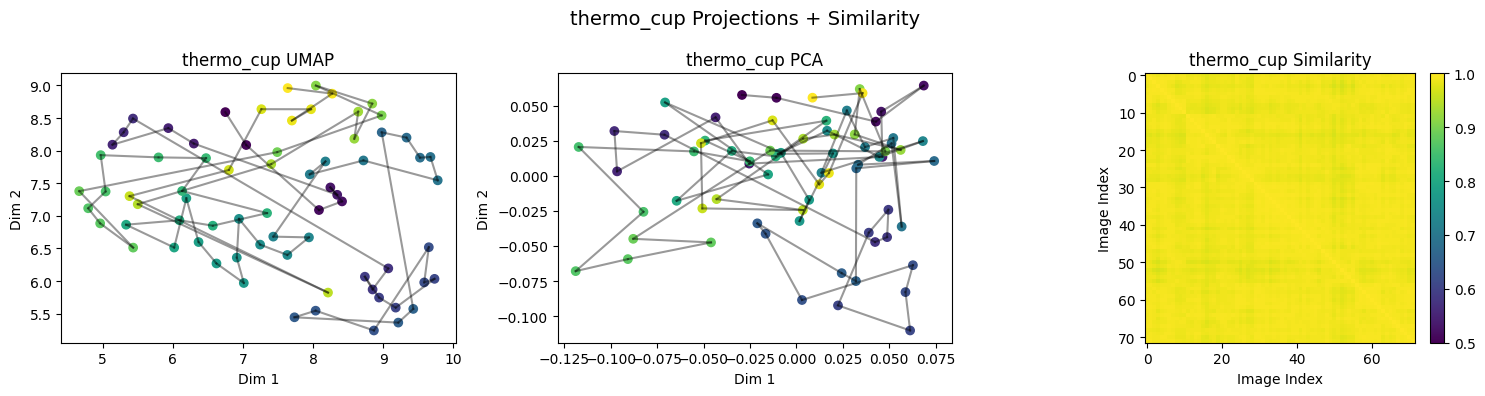

Analyzing 'light_bulb'...


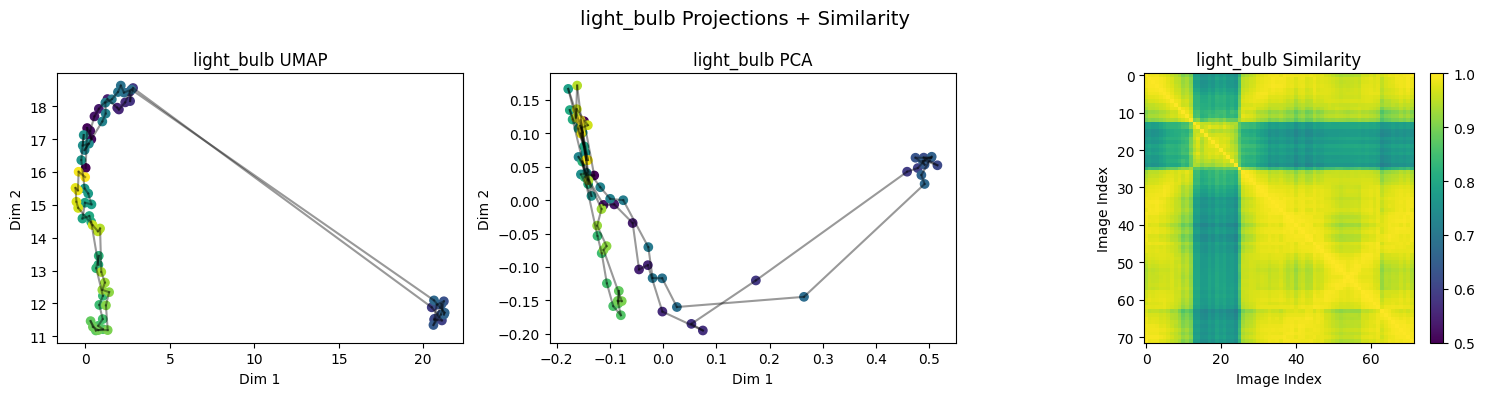

Analyzing 'cup_with_handle'...


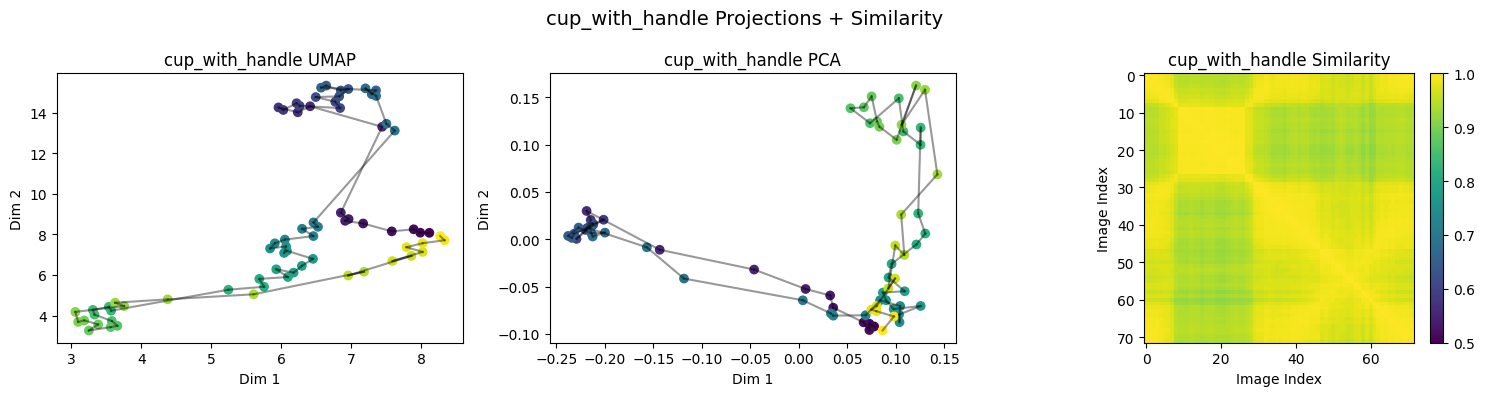

Analyzing 'combination_lock'...


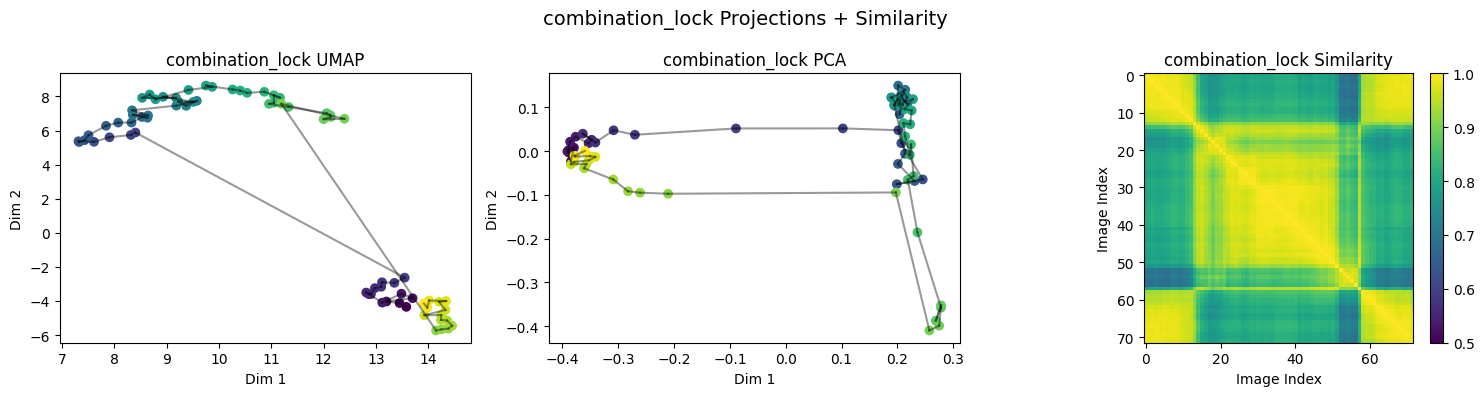

Analyzing 'wrist_watch'...


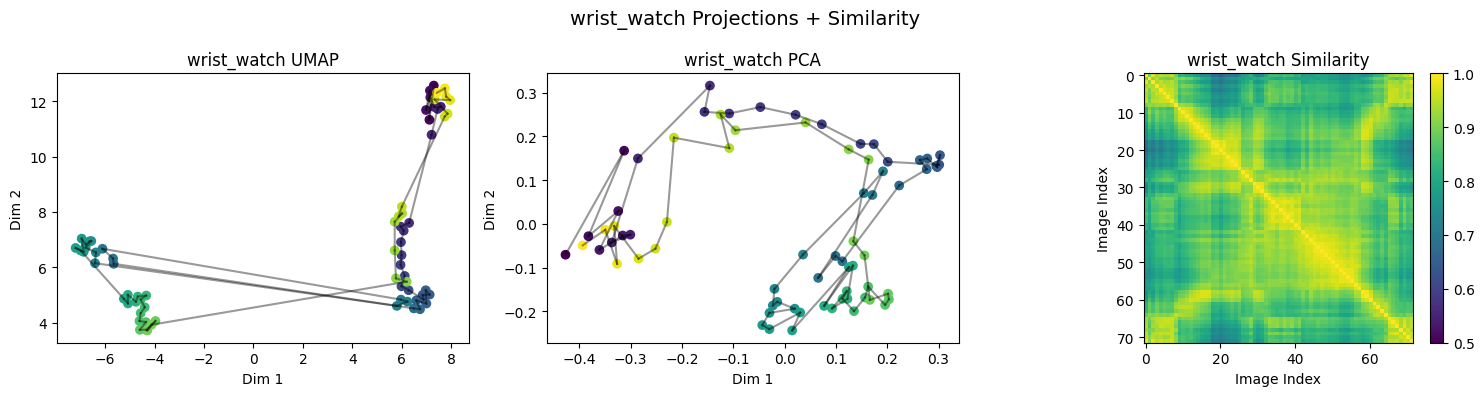

Analyzing 'toy_car'...


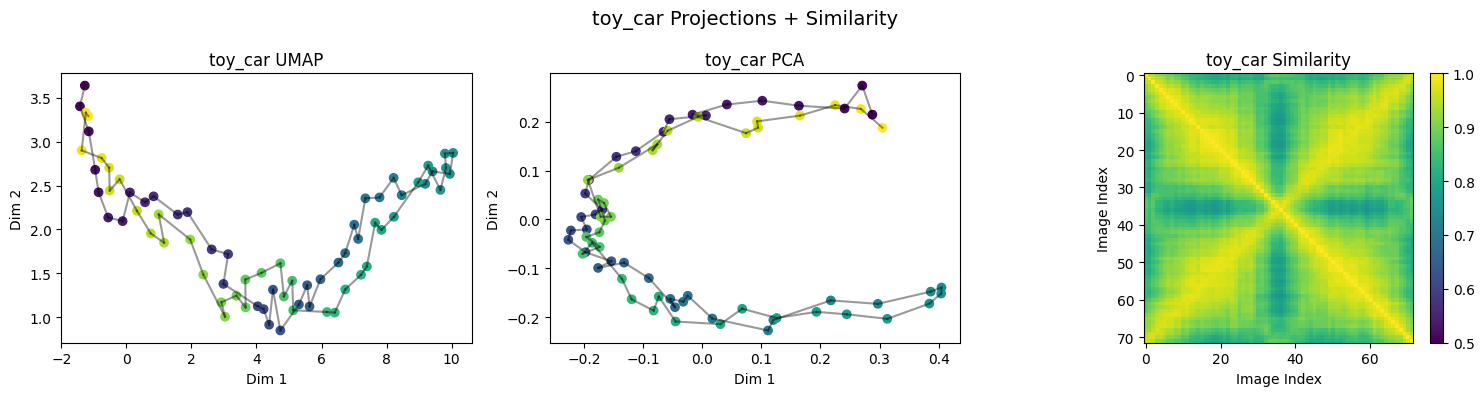

Analyzing 'lego_man'...


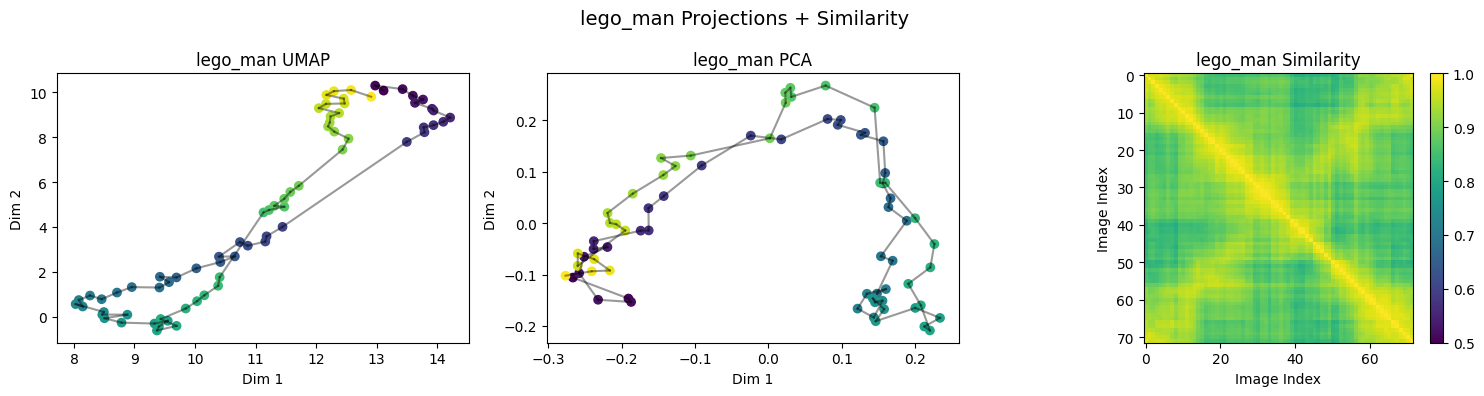

Analyzing 'sun_glasses'...


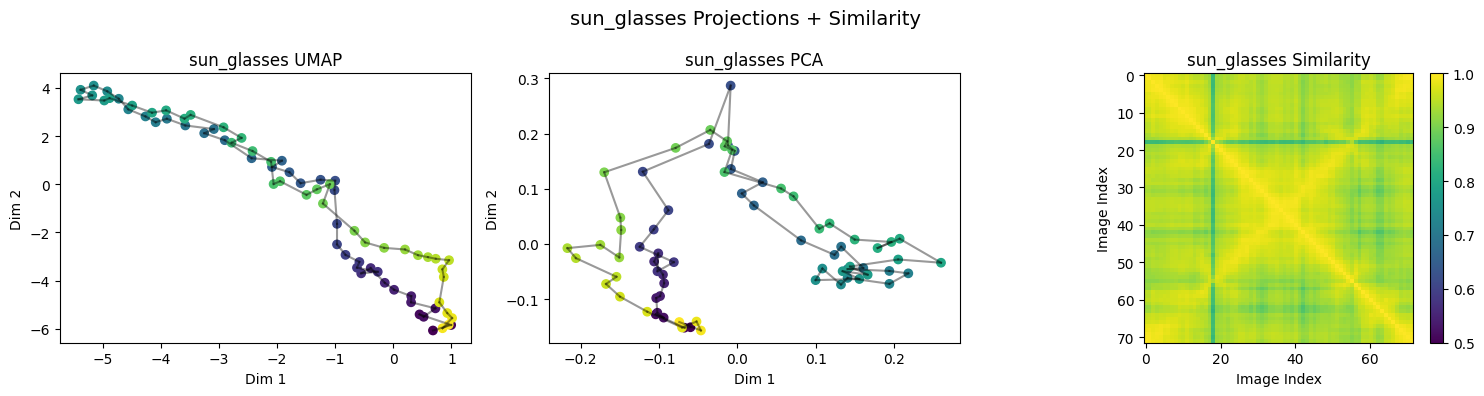

Analyzing 'faxe_kondi'...


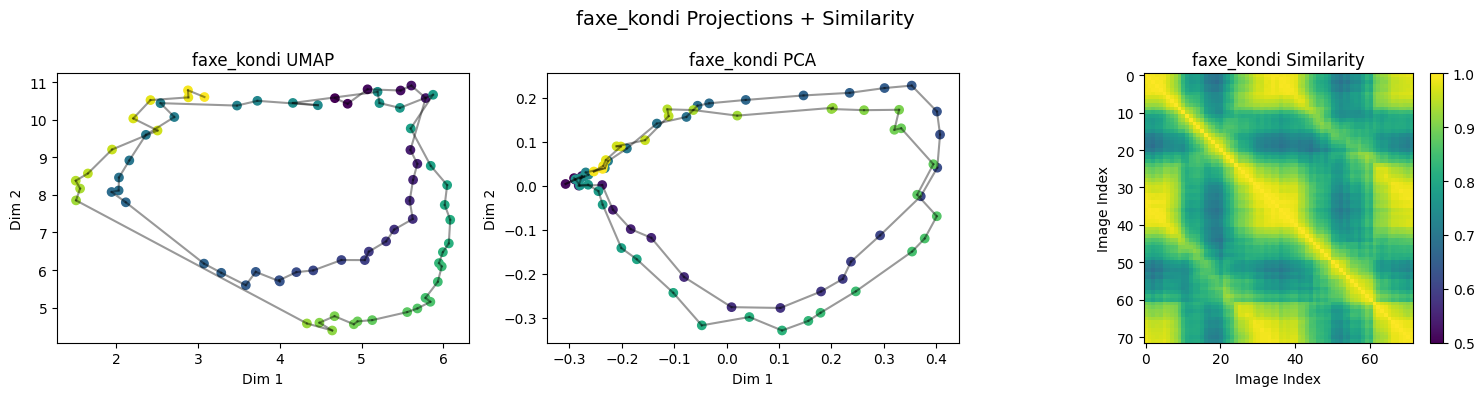

Analyzing 'lego_brick'...


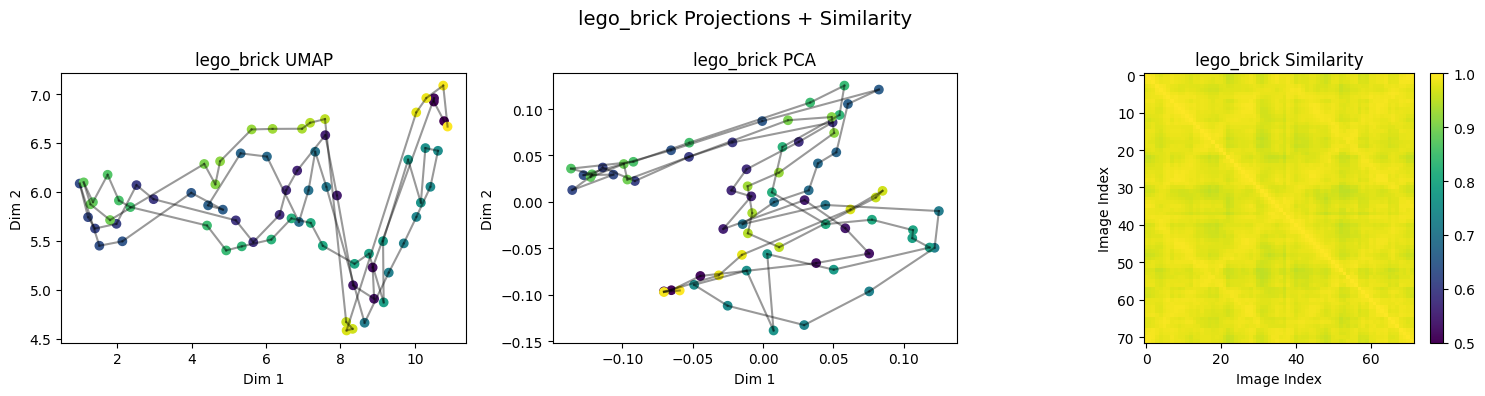

Analyzing 'controller'...


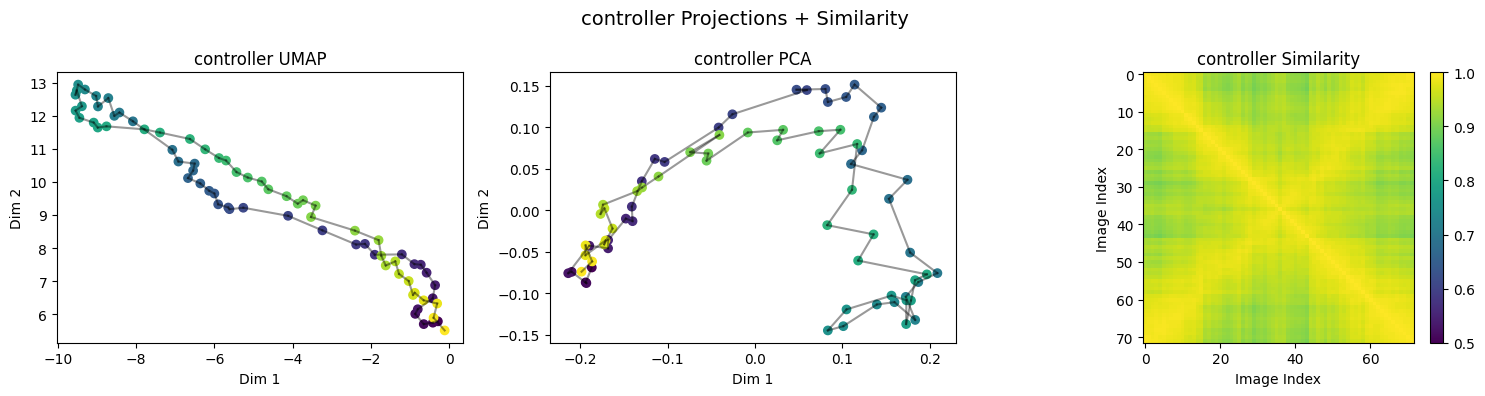

Analyzing 'duct_tape'...


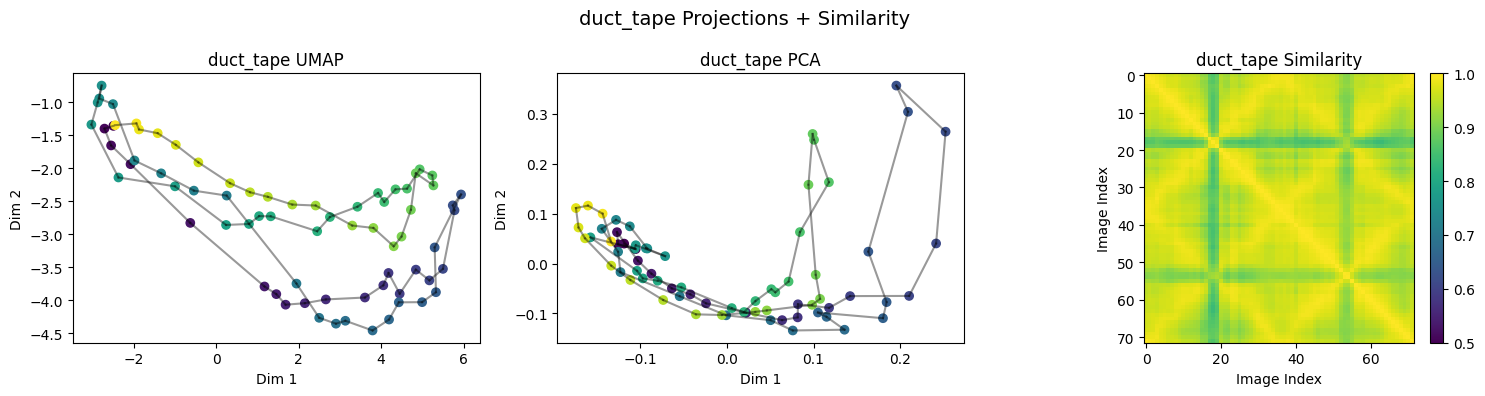


=== SUMMARY TABLE ===
Object       | Original | UMAP   | PCA    | Δ UMAP   | Δ PCA   
---------------------------------------------------------------
cup_no_handle | 5        | 3      | 2      | -2++++++ | -3++++++
charger      | 0        | 0      | 0      | 0+++++++ | 0+++++++
rubiks_cube  | 2        | 0      | 0      | -2++++++ | -2++++++
rubber_duck  | 3        | 0      | 0      | -3++++++ | -3++++++
battery      | 2        | 0      | 0      | -2++++++ | -2++++++
thermo_cup   | 2        | 3      | 3      | 1+++++++ | 1+++++++
light_bulb   | 3        | 8      | 1      | 5+++++++ | -2++++++
cup_with_handle | 4        | 3      | 0      | -1++++++ | -4++++++
combination_lock | 2        | 6      | 1      | 4+++++++ | -1++++++
wrist_watch  | 0        | 0      | 0      | 0+++++++ | 0+++++++
toy_car      | 1        | 0      | 0      | -1++++++ | -1++++++
lego_man     | 0        | 3      | 0      | 3+++++++ | 0+++++++
sun_glasses  | 2        | 0      | 0      | -2++++++ | -2++++++
faxe_kond

In [6]:


# ---------------- CONFIG ----------------
WINDOW_SIZE = 2
THRESHOLD_MODE = "std"   # options: "std", "percentile"
THRESHOLD_VALUE = 2      # percentile (e.g., 97) or std multiplier (e.g., 2.0)
RANDOM_SEED = 42
# ----------------------------------------

def project_embeddings(embeddings: np.ndarray, method: str = "umap") -> np.ndarray:
    if method == "umap":
        reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'umap' or 'pca'")
    return reducer.fit_transform(embeddings)

def detect_breakdowns(lengths: np.ndarray, mode: str, value: float) -> Tuple[np.ndarray, float]:
    if mode == "std":
        mean = np.mean(lengths)
        std = np.std(lengths)
        threshold = mean + value * std
    elif mode == "percentile":
        threshold = np.percentile(lengths, value)
    else:
        raise ValueError("Threshold mode must be 'std' or 'percentile'.")

    mask = lengths > threshold
    return mask, threshold

def analyze_embedding(name: str, embeddings: np.ndarray, show_plot: bool = False, fig=None, axes=None) -> Dict[str, int]:
    result = {}

    def get_breakdown_mask(emb, label):
        _, length_cvs = sliding_window(emb, window=WINDOW_SIZE)
        threshold = np.percentile(length_cvs, THRESHOLD_VALUE) if THRESHOLD_MODE == "percentile" else (
            np.mean(length_cvs) + THRESHOLD_VALUE * np.std(length_cvs)
        )
        mask = np.array(length_cvs) > threshold
        return mask, threshold, length_cvs

    # --- RAW EMBEDDINGS ---
    raw_mask, raw_thresh, raw_cvs = get_breakdown_mask(embeddings, "RAW")
    result["original"] = int(np.sum(raw_mask))

    # --- UMAP ---
    emb_umap = project_embeddings(embeddings, "umap")
    umap_mask, umap_thresh, umap_cvs = get_breakdown_mask(emb_umap, "UMAP")
    result["umap"] = int(np.sum(umap_mask))

    # --- PCA ---
    emb_pca = project_embeddings(embeddings, "pca")
    pca_mask, pca_thresh, pca_cvs = get_breakdown_mask(emb_pca, "PCA")
    result["pca"] = int(np.sum(pca_mask))

    # --- PLOTTING ---
    if show_plot and fig is not None and axes is not None:
        def plot_trajectory(ax, data, title):
            cmap = plt.get_cmap("viridis")
            norm = Normalize(vmin=0, vmax=len(data) - 1)
            for i in range(1, len(data)):
                ax.plot([data[i-1, 0], data[i, 0]],
                        [data[i-1, 1], data[i, 1]], 'k-', alpha=0.4)
            ax.scatter(data[:, 0], data[:, 1], c=np.arange(len(data)), cmap=cmap, norm=norm)
            ax.set_title(title)
            ax.set_xlabel("Dim 1")
            ax.set_ylabel("Dim 2")

        # UMAP plot
        plot_trajectory(axes[0], emb_umap, f"{name} UMAP")

        # PCA plot
        plot_trajectory(axes[1], emb_pca, f"{name} PCA")

        # Heatmap plot
        sim_matrix = cosine_similarity_matrix(embeddings)
        im = axes[2].imshow(sim_matrix, cmap="viridis", vmin=0.5, vmax=1.0)
        axes[2].set_title(f"{name} Similarity")
        axes[2].set_xlabel("Image Index")
        axes[2].set_ylabel("Image Index")
        plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

        #Want to include cool circle plot here axes[3] = circular_CV(param,param):

    return result


def batch_analyze(embedding_dict: Dict[str, np.ndarray], show_plot: bool = False):
    all_results = {}

    for key in embedding_dict:
        emb = embedding_dict[key]
        print(f"Analyzing '{key}'...")
        if show_plot:
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            results = analyze_embedding(key, emb, show_plot=True, fig=fig, axes=axes)
            plt.suptitle(f"{key} Projections + Similarity", fontsize=14)
            plt.tight_layout()
            plt.show()
        else:
            results = analyze_embedding(key, emb, show_plot=False)

        all_results[key] = results

    # Summary Table
    print("\n=== SUMMARY TABLE ===")
    header = f"{'Object':<12} | {'Original':<8} | {'UMAP':<6} | {'PCA':<6} | {'Δ UMAP':<8} | {'Δ PCA':<8}"
    print(header)
    print("-" * len(header))
    for key, res in all_results.items():
        o, u, p = res["original"], res["umap"], res["pca"]
        delta_u, delta_p = u - o, p - o
        print(f"{key:<12} | {o:<8} | {u:<6} | {p:<6} | {delta_u:+<8} | {delta_p:+<8}")

    return all_results

# Example usage
if __name__ == "__main__":

    batch_analyze(embedding_dict, show_plot=True)


In [ ]:
from scipy.stats import ttest_rel
import numpy as np

# Small statistics test
umap_counts = np.array([
    3, 0, 0, 0, 0, 3, 8, 3, 6, 0, 0, 3, 0, 4, 0, 0, 0
])
pca_counts = np.array([
    2, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0
])

# Paired t-test
t_stat, p_value = ttest_rel(umap_counts, pca_counts)

print(f"Paired t-test: t = {t_stat:.3f}, p = {p_value:.4f}")


diffs = umap_counts - pca_counts
from scipy.stats import shapiro

stat, p_shapiro = shapiro(diffs)
print(f"Shapiro-Wilk test: W = {stat:.3f}, p = {p_shapiro:.4f}")

# We cant use this test, have to use ranked

Paired t-test: t = 2.364, p = 0.0311
Shapiro-Wilk test: W = 0.744, p = 0.0004


In [124]:
from scipy.stats import wilcoxon

stat, p_wilcoxon = wilcoxon(umap_counts, pca_counts)
print(f"Wilcoxon signed-rank test: W = {stat}, p = {p_wilcoxon:.4f}")

Wilcoxon signed-rank test: W = 1.5, p = 0.0340
